In [49]:
import yaml
import json
from pathlib import Path
import pandas as pd
import torch

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/f_mnist/logs/decomposed_adam")

In [39]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 120


In [40]:
from datetime import datetime

dts = [datetime.fromtimestamp(int(x)) for x in folders]
print(max(dts))
print(min(dts))

2491-04-14 20:23:52
2022-02-16 13:31:57


In [41]:
# after = datetime(2022,2,14,19,0,0,0)
# before = datetime(2022,2,15,8,0,0,0)
# timestamps = []
# for ts, dt in ts_dts:
#     if dt > after and dt < before:
#         timestamps.append(ts)

In [42]:
paths = []
for folder in folders:
    found_decomp = False
    found_results = False
    for subfolder in os.listdir(logdir / folder):
        if 'lr' in subfolder:
            # found_decomp = True
            # break
            if (logdir / folder / subfolder / "results.json").exists():
                paths.append( logdir / folder / subfolder )
    # if not found_decomp or not found_results:
    #     folders.remove(folder)
print(len(paths))

120


In [43]:
# baseline

baseline_path = Path("/bigdata/f_mnist/logs/baselines/1644945876/rn18_18_dNone_256_adam_l0.001_g0.1_sTrue/cnn_best.pth")
baseline_model = torch.load(baseline_path)

In [35]:
def paths_to_results(paths):
    """Returns a pandas DataFrame with results"""
    results = []
    for path in paths:
        with open(path/'results.json') as json_file:
            result = json.load(json_file)
        results.append(result)
    
    keys = set()
    for result in results:
        keys = keys.union( set(result.keys()) )
    
    blank = {k:[] for k in keys}
    
    df = pd.DataFrame(blank) #.append(results[1], ignore_index=True)

    for result in results:
        df = df.append(result, ignore_index=True)
        
    df['compression'] = df['n_param_fact']/df['n_param'][0]
    df.compression[0] = 1.0
    
    
    return df

In [36]:
import torch
import tensorly as tl
tl.set_backend('pytorch')
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

def process_factorized_network(model, fact_model, layer_nrs, first_layer_nr=0):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers, 
        layer_nrs=layer_nrs
    )

    decomposed_numbered_layers_resnet18 = number_layers(fact_model)
    decomposed_conv_layers_resnet18 = listify_numbered_layers(
        decomposed_numbered_layers_resnet18, 
        layer_nrs=layer_nrs
    )

    errors_conv_resnet18 = {
        'name': [],
        'nr': [],
        'error': [],
    }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers_resnet18):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        print(name)
        nr = pre[1]
        print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        
        errors_conv_resnet18['name'].append(name)
        errors_conv_resnet18['nr'].append(nr)
        errors_conv_resnet18['error'].append(float(error))

    df_errors = pd.DataFrame(data=errors_conv_resnet18)
    if first_layer_nr is not None:
        df_errors.name.iloc[first_layer_nr] = 'in'
    df_errors.set_index('nr', inplace=True)
    grouped_errors = df_errors.groupby(by='name')
    grouped_errors['error'].plot(legend=True, style=".-", ylabel='Relative Error', xlabel='Layer Number')

In [37]:
# b = True
# for path in paths:
#     timestamp = Path(path).parent
#     config_path = logdir / timestamp / "config.yml"
#     config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
#     config_baseline_path = Path(config_data['baseline_path'])
#     if b:
#         print(config_baseline_path)
#         print(baseline_path)
#         print(10*"=")
#         b = False
#     if config_baseline_path != baseline_path:
#         print(config_baseline_path)
#         print(baseline_path)
#         print(10*"=")

/bigdata/f_mnist/logs/baselines/1644945876/rn18_18_dNone_256_adam_l0.001_g0.1_sTrue/cnn_best.pth
/bigdata/f_mnist/logs/baselines/1644945876/rn18_18_dNone_256_adam_l0.001_g0.1_sTrue/cnn_best.pth


In [45]:
# calc approximation error
# store in approx_error.json, next to results.json
import yaml

for path in paths:
    print(path)
    timestamp = Path(path).parent
    config_path = logdir / timestamp / "config.yml"
    config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
    layers = config_data['layers']

    fact_model = torch.load(path / 'fact_model_best.pth')

    pretrained_numbered_layers = number_layers(baseline_model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers,
        layer_nrs=layers,
    )

    decomposed_numbered_layers = number_layers(fact_model)
    decomposed_conv_layers = listify_numbered_layers(
        decomposed_numbered_layers,
        layer_nrs=layers,
    )

    with open(path / 'results.json') as json_file:
        result = json.load(json_file)

    with open(path / 'results_before_training.json') as json_file:
        result_before_training = json.load(json_file)

    errors_conv = {
            'name': [],
            'nr': [],
            'error': [],
            'layers': layers,
            'factorization': config_data['factorization'],
            'rank': config_data['rank'],
            'valid_acc': result['best_valid_acc'],
            'valid_acc_before_ft': result_before_training['valid_acc'],
            'n_param_fact': result['n_param_fact'],
            'test_acc': result['test_acc'],
            'lr': config_data['lr'],
            'optimizer': config_data['optimizer'],
        }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        # print(name)
        nr = pre[1]
        # print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        # print(error)
        
        errors_conv['name'].append(name)
        errors_conv['nr'].append(nr)
        errors_conv['error'].append(float(error))

    errors_path = logdir / path / 'results_approximation_error.json'
    with open(errors_path, 'w') as f:
        json.dump(errors_conv, f)

/bigdata/f_mnist/logs/decomposed_adam/1645047993/rn18-lr-[38]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645048960/rn18-lr-[44]-cp-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645017615/rn18-lr-[28]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645030534/rn18-lr-[28]-tucker-0.75-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645023670/rn18-lr-[15]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645048639/rn18-lr-[41]-tucker-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645047643/rn18-lr-[38]-cp-0.5-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645037585/rn18-lr-[28]-tucker-0.9-dTrue-iNone_bn_256_sgd_l1e-05_g0.0_sTrue
/bigdata/f_mnist/logs/decomposed_adam/1645031732/rn18-lr-[28]-tucker-0.9-dTrue-iNone_bn_256_sgd

In [46]:
results = []
for path in paths:
    with open(path / 'results_approximation_error.json') as json_file:
        result = json.load(json_file)
    print(result)
    for k,v in result.items():
        result[k] = v[0] if type(v) == list else v
    results.append(result)

{'name': ['conv2'], 'nr': [38], 'error': [0.4174429178237915], 'layers': [38], 'factorization': 'tucker', 'rank': 0.5, 'valid_acc': 0.9566, 'valid_acc_before_ft': 0.956, 'n_param_fact': 10878589, 'test_acc': 0.9445, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv1'], 'nr': [44], 'error': [0.32221436500549316], 'layers': [44], 'factorization': 'cp', 'rank': 0.5, 'valid_acc': 0.9566, 'valid_acc_before_ft': 0.9566, 'n_param_fact': 10878297, 'test_acc': 0.9448, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv1'], 'nr': [28], 'error': [0.5389806628227234], 'layers': [28], 'factorization': 'tucker', 'rank': '0.50', 'valid_acc': 0.9528, 'valid_acc_before_ft': 0.9512, 'n_param_fact': 11098445, 'test_acc': 0.9451, 'lr': 1e-05, 'optimizer': 'adam'}
{'name': ['conv1'], 'nr': [28], 'error': [0.3925037086009979], 'layers': [28], 'factorization': 'tucker', 'rank': '0.75', 'valid_acc': 0.955, 'valid_acc_before_ft': 0.9534, 'n_param_fact': 11136896, 'test_acc': 0.9453, 'lr': 1e-05, 'optimizer': 'ad

In [47]:
df = pd.DataFrame(results)


In [48]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()

array([0.5 , 0.75, 0.9 , 0.1 , 0.25])

In [50]:
df.set_index('rank', inplace=True)

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: error, dtype: object

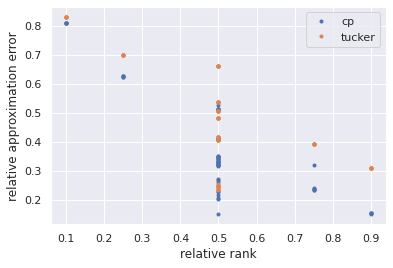

In [51]:
grouped_df = df.groupby('factorization')
grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error', xlabel='relative rank')

<AxesSubplot:xlabel='rank', ylabel='error'>

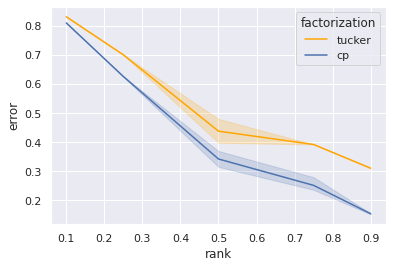

In [52]:
df = pd.DataFrame(results)
df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

In [125]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc, dtype: object

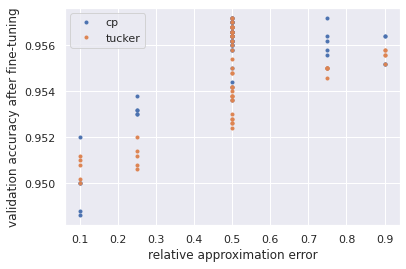

In [53]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

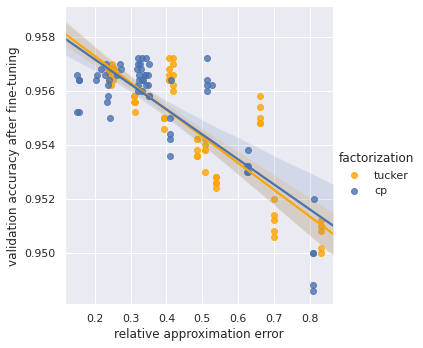

In [54]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

In [55]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,fact_rank
0,conv2,38,0.417443,38,tucker,0.50,0.9566,0.9560,10878589,0.9445,0.00001,adam,tucker-0.5
1,conv1,44,0.322214,44,cp,0.50,0.9566,0.9566,10878297,0.9448,0.00001,adam,cp-0.5
2,conv1,28,0.538981,28,tucker,0.50,0.9528,0.9512,11098445,0.9451,0.00001,adam,tucker-0.5
3,conv1,28,0.392504,28,tucker,0.75,0.9550,0.9534,11136896,0.9453,0.00001,adam,tucker-0.75
4,conv2,15,0.508425,15,tucker,0.50,0.9538,0.9532,11154645,0.9453,0.00001,adam,tucker-0.5


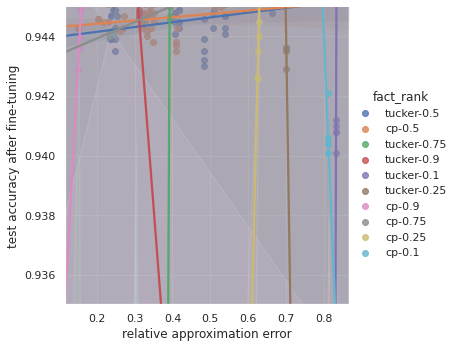

In [56]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="fact_rank", 
   data=df,
   truncate=False, 
   # palette=['orange','b'],
)
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
g.set(ylim=(0.935, 0.945))

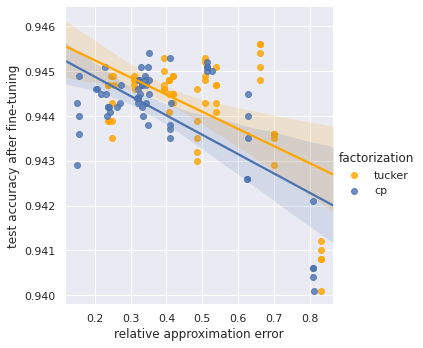

In [57]:
g = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   truncate=False, 
   palette=['orange','b'],
)
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc_before_ft, dtype: object

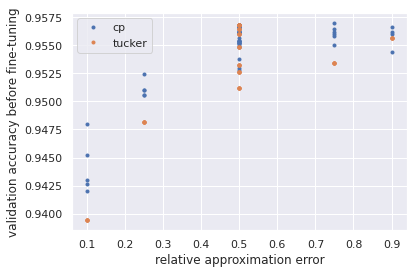

In [58]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

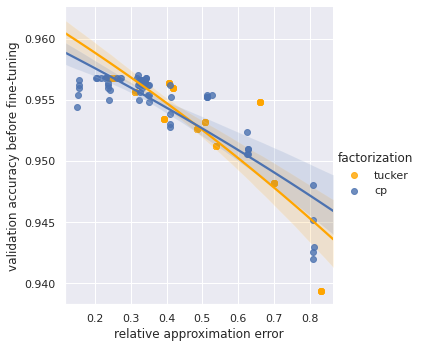

In [59]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [69]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer
0,conv2,38,0.417443,38,tucker,0.5,0.9566,0.9560,10878589,0.9445,0.00001,adam
1,conv1,44,0.322214,44,cp,0.5,0.9566,0.9566,10878297,0.9448,0.00001,adam
2,conv1,28,0.538981,28,tucker,0.5,0.9528,0.9512,11098445,0.9451,0.00001,adam
4,conv2,15,0.508425,15,tucker,0.5,0.9538,0.9532,11154645,0.9453,0.00001,adam
5,0,41,0.661844,41,tucker,0.5,0.9548,0.9548,11156556,0.9456,0.00001,adam
...,...,...,...,...,...,...,...,...,...,...,...,...
114,conv1,60,0.249200,60,tucker,0.5,0.9564,0.9568,9995872,0.9449,0.00001,adam
115,conv1,28,0.411286,28,cp,0.5,0.9564,0.9552,11099257,0.9443,0.00001,adam
117,conv1,44,0.405992,44,tucker,0.5,0.9564,0.9564,10878589,0.9441,0.00001,adam
118,conv1,44,0.339660,44,cp,0.5,0.9566,0.9564,10878297,0.9448,0.00001,adam


factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: error, dtype: object

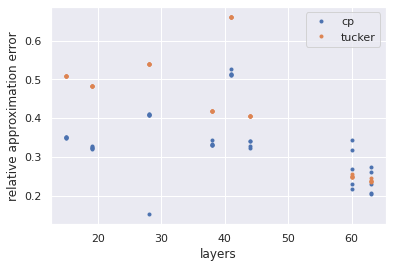

In [71]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc, dtype: object

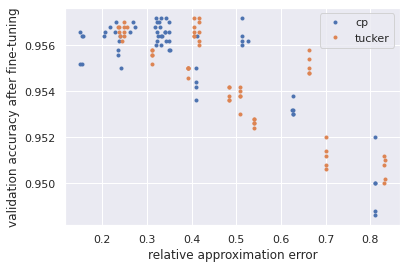

In [72]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

factorization
cp        AxesSubplot(0.125,0.125;0.775x0.755)
tucker    AxesSubplot(0.125,0.125;0.775x0.755)
Name: valid_acc_before_ft, dtype: object

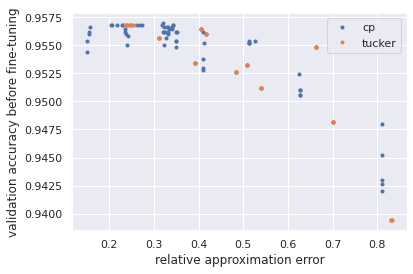

In [63]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

<AxesSubplot:xlabel='layers', ylabel='error'>

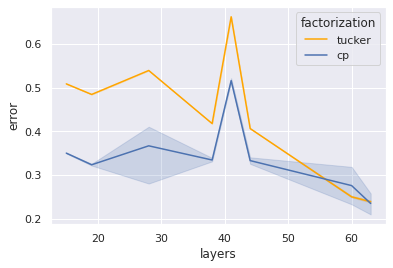

In [73]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

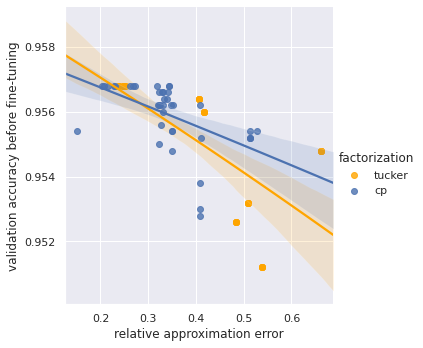

In [74]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')